In [2]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter, UnsupervisedSampler
from stellargraph.layer import link_classification
from tensorflow import keras
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

# Load Custom Dataset

In [3]:
from networkx.readwrite import json_graph
import json

In [4]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [5]:
# %time
transport=read_json_file("bus_transport_graph_extra_feat.json")
transport.nodes()['78031']

{'type': 'bus_stop', 'latitude': 1.366365, 'longitude': 103.958641}

In [8]:
g_feature_attr = transport.copy()


def compute_features(lat, lon, adj_dic, pop_est, pop_mult, flow):
    # in general this could compute something based on other features, but for this example,
    # we don't have any other features, so we'll just do something basic with the node_id
    lnt=len(adj_dic)
    lnt=max(lnt, 1)
    return [flow/lnt, pop_mult, pop_est/lnt]


adj_dict={}
for n, ndict in transport.adjacency():
    n_list=list(ndict.keys())
    adj_dict[n]=n_list
# print(adj_dict)

for node_id, node_data in g_feature_attr.nodes(data=True):
    try:
       est= node_data['pop_estimate']
       mul=node_data["pop_multiplier"]
       fl=node_data["avg_flow"]
    except:
        est= 0
        mul=0
        fl=0
        
    node_data["feature"] = compute_features(node_data["latitude"],node_data["longitude"], adj_dict[node_id], est, mul, fl)
    
# let's see what some of them look like:
g_feature_attr.nodes["75009"]

ZeroDivisionError: division by zero

In [315]:
transport_sg=StellarGraph.from_networkx(g_feature_attr, node_type_default="bus_stop", edge_type_default="bus_route", node_features='feature')
print(transport_sg.info())

StellarDiGraph: Directed multigraph
 Nodes: 5083, Edges: 7459

 Node types:
  bus_stop: [5083]
    Features: float32 vector, length 3
    Edge types: bus_stop-bus_route->bus_stop

 Edge types:
    bus_stop-bus_route->bus_stop: [7459]
        Weights: range=[0, 37.8], mean=0.797319, std=2.41502
        Features: none


c:\Users\Kiran\miniconda3\envs\dpenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: found the following nodes (of type 'bus_stop') without features, using 3-dimensional zero vector: '78031', '78181', '78191', '98111', '98109', '98031', '98041', '98231', '98051', '98061', '98071', '99011', '99021', '99031', '99041', '99139', '99009', '99131', '99049', '99039', ... (4454 more)
  """Entry point for launching an IPython kernel.


In [258]:
# Define an edge splitter on the original graph:
edge_splitter_graph = EdgeSplitter(transport_sg)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_graph.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())
print(len(examples_test), len(labels_test))

** Sampled 745 positive and 745 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 5083, Edges: 6714

 Node types:
  bus_stop: [5083]
    Features: float32 vector, length 3
    Edge types: bus_stop-bus_route->bus_stop

 Edge types:
    bus_stop-bus_route->bus_stop: [6714]
        Weights: range=[0, 37.8], mean=0.793715, std=2.38649
        Features: none
1490 1490


In [259]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
print(graph_train.info())
print(len(examples), len(labels))

** Sampled 671 positive and 671 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 5083, Edges: 6043

 Node types:
  bus_stop: [5083]
    Features: float32 vector, length 3
    Edge types: bus_stop-bus_route->bus_stop

 Edge types:
    bus_stop-bus_route->bus_stop: [6043]
        Weights: range=[0, 37.8], mean=0.795151, std=2.40782
        Features: none
1342 1342


In [260]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,1342,Train Graph,Test Graph,Train the Link Classifier
Test set,1490,Test Graph,Full Graph,Evaluate the best Link Classifier


# Model Definitions

## embeddings

In [205]:
from stellargraph.data import BiasedRandomWalk


def create_biased_random_walker(graph, walk_num, walk_length):
    # parameter settings for "p" and "q":
    p = 1.0
    q = 1.0
    return BiasedRandomWalk(graph, n=walk_num, length=walk_length, p=p, q=q)

In [261]:
walk_length=10
epochs=20
batch_size=32

In [267]:
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec


def attri2vec_embedding(graph, name):

    # Set the embedding dimension and walk number:
    dimension = [128]
    walk_number = 4

    print(f"Training Attri2Vec for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define an Attri2Vec training generator, which generates batches of training pairs
    generator = Attri2VecLinkGenerator(graph, batch_size)

    # Create the Attri2Vec model
    attri2vec = Attri2Vec(
        layer_sizes=dimension, generator=generator, bias=False, normalize=None
    )

    # Build the model and expose input and output sockets of Attri2Vec, for node pair inputs
    x_inp, x_out = attri2vec.in_out_tensors()

    # Use the link_classification function to generate the output of the Attri2Vec model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
    )(x_out)

    # Stack the Attri2Vec encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy], 
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=1,
        use_multiprocessing=False,
        workers=1,
        shuffle=True,
    )

    # Build the model to predict node representations from node features with the learned Attri2Vec model parameters
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = Attri2VecNodeGenerator(graph, batch_size).flow(graph_node_list)
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

## Pipeline

In [268]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=5000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    # print(link_features_test)
    score,preds = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    
    return score,preds


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)
    
    
    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column]),predicted

In [269]:
def operator_l2(u, v):
    return (u - v) ** 2



# def run_link_prediction(binary_operator, embedding_train):
#     clf = train_link_prediction_model(
#         examples_train, labels_train, embedding_train, binary_operator
#     )
#     # score, preds, pos_col = evaluate_link_prediction_model(
#     #     clf,
#     #     examples_model_selection,
#     #     labels_model_selection,
#     #     embedding_train,
#     #     binary_operator,
#     # )
#     return clf
#     return {
#         "classifier": clf,
#         # "binary_operator": binary_operator,
#         # "score": score,
#     }


# binary_operators = [ operator_l2]

In [270]:
def train_and_evaluate(embedding, graph=graph_test):
    
    embedding_train = embedding(graph, "Train Graph")

    # Train the link classification model with the learned embedding
    clf = train_link_prediction_model(
        examples, labels, embedding_train, operator_l2
    )
    
    test_score, preds= evaluate_link_prediction_model(
        clf,
        examples_test,
        labels_test,
        embedding_train,
        operator_l2)

    return embedding_train, clf, test_score, preds

# Training

In [271]:
emb_fn, clf, attri2vec_result, preds= train_and_evaluate(attri2vec_embedding)

Training Attri2Vec for 'Train Graph':
link_classification: using 'ip' method to combine node embeddings into edge embeddings
  ...
    to  
  ['...']
Train for 11394 steps
Epoch 1/20
11394/11394 [==============================] - 104s 9ms/step - loss: 0.7146 - binary_accuracy: 0.5141
Epoch 2/20
11394/11394 [==============================] - 107s 9ms/step - loss: 0.7148 - binary_accuracy: 0.5203
Epoch 3/20
11394/11394 [==============================] - 93s 8ms/step - loss: 0.7151 - binary_accuracy: 0.5208
Epoch 4/20
11394/11394 [==============================] - 95s 8ms/step - loss: 0.7150 - binary_accuracy: 0.5204
Epoch 5/20
11394/11394 [==============================] - 103s 9ms/step - loss: 0.7149 - binary_accuracy: 0.5221
Epoch 6/20
11394/11394 [==============================] - 104s 9ms/step - loss: 0.7136 - binary_accuracy: 0.5233
Epoch 7/20
11394/11394 [==============================] - 98s 9ms/step - loss: 0.7070 - binary_accuracy: 0.5363
Epoch 8/20
11394/11394 [================

In [272]:
print(attri2vec_result)

0.9866384397099229


In [273]:
len(preds[:, 0]), len(labels_test)

(1490, 1490)

In [215]:
examples_test.shape

(1490, 2)

# Test

In [226]:
# transport.nodes()

In [274]:
transport.adjacency()

In [275]:
adj_dict={}

for n, ndict in transport.adjacency():
    n_list=list(ndict.keys())
    adj_dict[n]=n_list
len(adj_dict)

5083

In [276]:
prediction_list=[]
for node in transport.nodes():
    existing_connect=adj_dict[node]
    for node2 in transport.nodes():
        if node2 not in existing_connect:
            
            prediction_list.append([node, node2])

In [277]:
len(prediction_list)

25829430

In [278]:
from random import sample
pred_arr=np.asarray(sample(prediction_list, 10000))

# Misc

In [296]:
print(pred_arr)

[['10201' '44589']
 ['47509' '84009']
 ['55509' '41131']
 ...
 ['22409' '12141']
 ['68171' '07571']
 ['24691' '56099']]


In [297]:
%%time
link_features_test = link_examples_to_features(
        potential_connections, emb_fn, operator_l2
    )
predictions_prob = clf.predict_proba(link_features_test)
predictions = clf.predict(link_features_test)

Wall time: 41.9 s


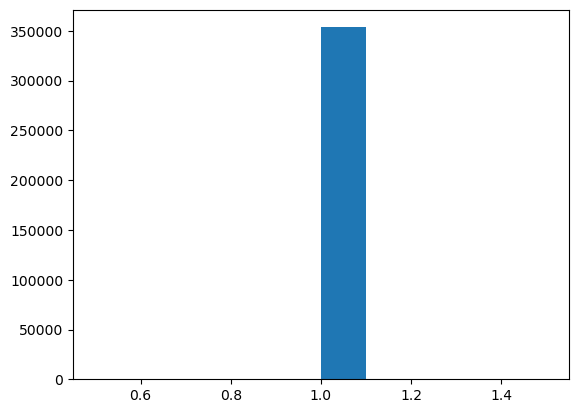

In [298]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(predictions)
plt.show()

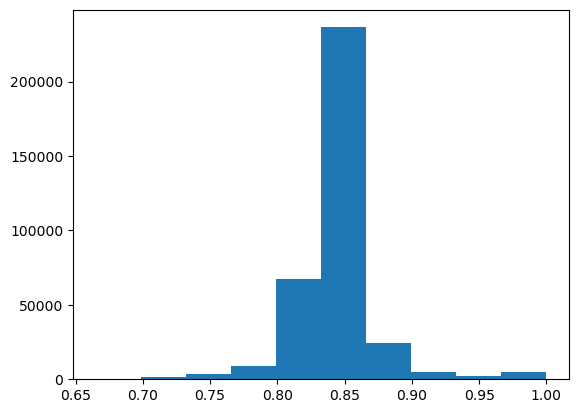

In [299]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(predictions_prob[:,1])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1cf33113408>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf33113d08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf3357ebc8>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf33118948>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf33118f48>],
 'means': []}

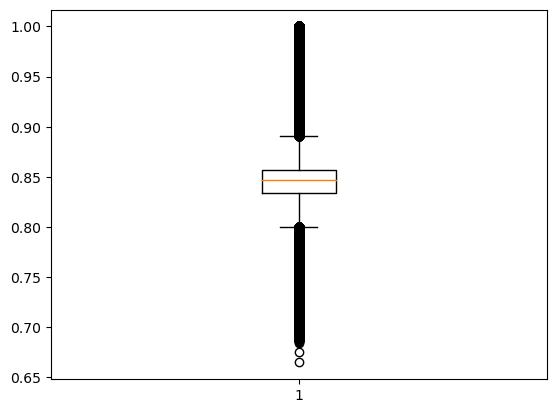

In [300]:
plt.boxplot(predictions_prob[:,1])

In [301]:
import pickle
with open('potential_connections.pkl', 'rb') as f:
    potential_connections = pickle.load(f)

In [302]:
import pandas as pd

In [303]:
potential_connections

array([['70201', '71091'],
       ['05019', '05259'],
       ['43321', '28471'],
       ...,
       ['11139', '10421'],
       ['54251', '54579'],
       ['77051', '78221']], dtype='<U5')

In [304]:
df=pd.DataFrame({"Links":[p for p in potential_connections], "probability": predictions_prob[:,1]})

In [305]:
df.sort_values(by=["probability"], ascending=False, inplace=True, ignore_index=True)

In [306]:
df_save=df[:200]

In [307]:
df_save.head()

,Links,probability
0,"[59091, 59599]",1.0
1,"[59599, 59231]",1.0
2,"[59599, 59351]",1.0
3,"[03218, 10059]",1.0
4,"[59599, 59579]",1.0


In [308]:
df.to_csv("top_links.csv", index=False)

In [293]:
transport.nodes()['03218']

{'type': 'bus_stop',
 'latitude': 1.2740788888387,
 'longitude': 103.84687388890413}

In [294]:
transport.nodes()['06051']

{'type': 'bus_stop',
 'latitude': 1.28475980959972,
 'longitude': 103.83405671725487}